# Objectif 

Réaliser un projet de data science de bout en bout à partir de données de cas d’usage réel. L’objectif sera alors d’appliquer un algorithme d’apprentissage automatique et/ou de réseau neuronal sur un ensemble de données réelles.

Data :
Vous avez 2 sujets donc 2 jeux de données à votre disposition. Vous devez choisir un ensemble de données parmi les 2.


## 1. `Supervision de lignes de bus`

Les transports publics font face tous les jours à des flux de passagers différents. Dans le cadre de sa mission d’amélioration des services proposés à ses usagers, une société souhaite être en mesure (à terme) de :
- Anticiper les fortes affluences d’usagers sur l’ensemble de son réseau en ayant une vision claire des demandes pour chaque ligne et pour chaque arrêt.
- Optimiser les temps de trajets de sa flotte

L’objet de ce challenge est donc de prédire l’affluence des passagers sur des lignes de bus, par jour, pour les 3 prochains jours.

    - Vous aurez à disposition un historique du cumul journalier de voyageurs allant du 05 avril 2019 au 19 mars 2023, pour toutes les lignes de bus de la compagnie. 
    - Le jeu de données est composé de 37 621 observations et 3 variables explicatives originales qui sont, la date, la ligne de bus et le type de ligne de bus (jour ou nuit). 
    - La variable quantitative à prédire est le nombre de passagers/usagers.  

    Variable de sortie : 
    - Nombre de passagers (variable numérique continue) 

## 2. `Détection de fuite`

Pour un opérateur public de distribution d’eau, la détection rapide des fuites sur le réseau est un enjeu stratégique majeur. 
Les équipes terrain interviennent quotidiennement sur des milliers de kilomètres de canalisation, où les fuites peuvent passer inaperçues et entraîner des pertes  importantes d’eau, des coûts élevés et des  perturbations du service.

HUPI travaille depuis plusieurs mois afin de développer un Assistant Virtuel de détection de fuites, basé sur des modèles de Machine Learning. 
Cet assistant prend en compte :
- les caractéristiques du réseau, 
- les données historiques de consommation et de pression, 
- ainsi que le profil et les habitudes de fonctionnement du réseau, afin d’alerter automatiquement et judicieusement lorsqu’un risque de fuite est détecté.

L’objectif est de concevoir des modèles auto-apprenants, capables de s’adapter aux spécificités de chaque zone géographique et de chaque type d’infrastructure, afin de générer des alertes personnalisées et adaptées à chaque contexte de réseau.

Vous disposez d’un ensemble de données contenant les mesures quotidiennes de consommation d’eau pour 502 compteurs différents. Chaque ligne correspond à une observation d’un compteur à une date donnée.

Les variables sont les suivantes :
    
    - valeur_active : consommation mesurée (en m³)
    - valeur_date : date de la mesure (quotidienne)
    - libelle : identifiant du compteur (502 valeurs différentes)


L’objectif du projet est d’analyser et de caractériser la consommation d’eau des différents compteurs. Pour répondre à cette problématique, trois tâches principales peuvent être menées :
- Prédire la consommation future des compteurs à partir de leurs historiques.
- Identifier la tendance de la consommation (hausse, stabilité, baisse).
- Classer les niveaux de consommation (faible, moyen, fort) pour caractériser les comportements des compteurs.

# chargement de l'environnement virtuel

source ~/python_envs/projet_hupi/bin/activate

pip install pandas scikit-learn seaborn

In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import math

## fonctions utiles

In [82]:
def impression(data, libelles=[], metrics=[]):
    if not libelles:
        libelles = data["libelle"].unique().tolist()

    n = len(libelles)

    if n==0:
        pass
    
    n_cols = 3
    n_rows = math.ceil(n / n_cols)  # nombre de lignes nécessaires
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # aplatir pour itérer facilement    

    for i, libelle in enumerate(libelles):
        mask=data["libelle"] == libelle
        titre= f" metric={str(metrics[i])}" if len(metrics)>i else ""
        titre+=str(libelle)
        try:
            df = data[mask].sort_values("date")
            axes[i].plot(df["date"], df["valeur_active"])
            axes[i].set_title(libelle)         
            axes[i].set_ylim(0, df["valeur_active"].max() * 1.1)
            axes[i].set_ylabel('Valeur compteur')
            axes[i].tick_params(axis='x',labelrotation=45)
        except:
            pass
    # Supprimer les axes vides si n < n_rows*n_cols
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


## Chargement des données

In [83]:
#%python_ecole
file_path = "./data/"
project_name_eau = "detection_fuite.csv"

print("*** Chargement des données *** \n")
data_eau = pd.read_csv(f"{file_path}/{project_name_eau}")
print(f"Affichage des premières lignes du dataset : \n\n {data_eau.head()} \n\n")
print(f"Dimension du dataset : {data_eau.shape}")

*** Chargement des données *** 

Affichage des premières lignes du dataset : 

    valeur_active valeur_date libelle
0           35.0  2019-01-01    ID_1
1            0.0  2019-01-01    ID_2
2            2.0  2019-01-01    ID_3
3           38.0  2019-01-01    ID_4
4           38.0  2019-01-01    ID_5 


Dimension du dataset : (470900, 3)


# Exploration globale des données

## analyse de la valeur_active

In [84]:
data_eau.describe()

,valeur_active
count,4.488080e+05
mean,1.160575e+03
std,3.013335e+05
min,-8.740000e+01
25%,7.972603e-01
50%,5.100000e+00
75%,2.000000e+01
max,9.999999e+07


(array([1.67664e+05, 1.57890e+05, 5.89860e+04, 4.57700e+03, 4.00000e+00,
        7.00000e+00, 0.00000e+00, 8.30000e+01, 6.00000e+00, 4.00000e+00]),
 array([9.99500333e-04, 1.84296762e+00, 3.68493574e+00, 5.52690385e+00,
        7.36887197e+00, 9.21084009e+00, 1.10528082e+01, 1.28947763e+01,
        1.47367444e+01, 1.65787126e+01, 1.84206807e+01]),
 <BarContainer object of 10 artists>)

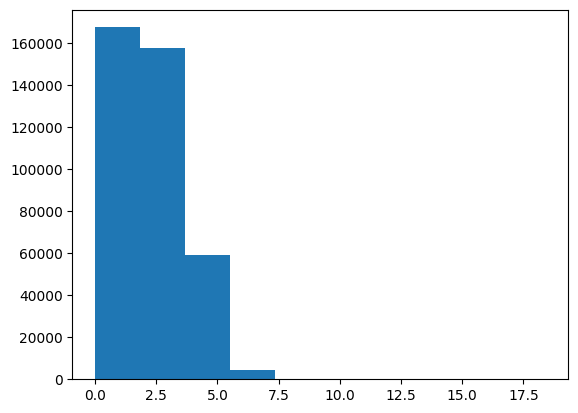

In [85]:
plt.hist(np.log1p(data_eau[data_eau['valeur_active']>0]['valeur_active']))

Il y a des valeurs nulles et quelques valeurs extremes à retirer

## nettoyage

Convertir la colonne valeur_date en type datetime qui sera plus facile à manipuler avec pandas et retirer les valeurs nan ou négatives

In [86]:
# conversion date
data_eau["date"] = pd.to_datetime(data_eau["valeur_date"])
data_eau=data_eau.sort_values("date")

# retirer valeur négatives
data_eau[data_eau['valeur_active']<0]=np.nan

# retirer les valeurs extrèmes
data_eau[data_eau['valeur_active']>np.expm1(7.5)]=np.nan

# retirer nan
data_eau = data_eau[data_eau["valeur_active"].notna()].copy()
data_eau.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448597 entries, 0 to 470899
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   valeur_active  448597 non-null  float64       
 1   valeur_date    448597 non-null  object        
 2   libelle        448597 non-null  object        
 3   date           448597 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 17.1+ MB


In [87]:
data_eau.describe()

,valeur_active,date
count,448597.000000,448597
mean,22.282182,2023-06-07 01:12:53.186624
min,0.000000,2019-01-01 00:00:00
25%,0.798434,2022-09-25 00:00:00
50%,5.100000,2023-07-28 00:00:00
75%,20.000000,2024-04-22 00:00:00
max,1561.700000,2024-12-31 00:00:00
std,54.137274,NaN


## Analyse du nombre de compteur actif

In [88]:
data_metrics = (
    data_eau
      .groupby(data_eau['date'].dt.to_period('D'))
      .agg(
          nb_unique_libelle=("libelle", "nunique"),
          nb_valeur_active=("valeur_active", "count"),
          min_valeur_active=("valeur_active", "min"),
          max_valeur_active=("valeur_active", "max"),
          moy_valeur_active=("valeur_active", "mean"),
      )
)

In [89]:
data_metrics.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2192 entries, 2019-01-01 to 2024-12-31
Freq: D
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nb_unique_libelle  2192 non-null   int64  
 1   nb_valeur_active   2192 non-null   int64  
 2   min_valeur_active  2192 non-null   float64
 3   max_valeur_active  2192 non-null   float64
 4   moy_valeur_active  2192 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 102.8 KB


<Axes: xlabel='date'>

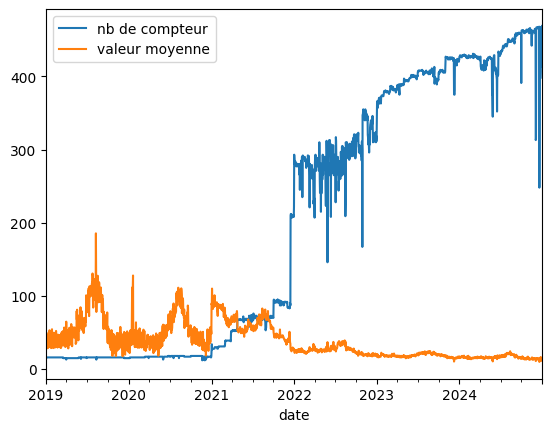

In [90]:
data_metrics['nb_unique_libelle'].plot(label="nb de compteur", legend=True)
data_metrics['moy_valeur_active'].plot(label="valeur moyenne", legend=True)


Il existe quatre périodes :
- 2019-2020 : 20 compteurs
- 2021 : ajout progressif d'une centaine de compteurs
- 2022 : ajout de 200 compteurs avec beaucoup de valeurs manquantes
- 2023-2024 : stabilisation des valeurs et ajout progressif jusqu'à un total de 450 compteurs

# Exploration des compteurs

## sélection des dates

On explore sur la période 2022-24 qui est celle avec le plus de compteurs

In [91]:
start_date = "2022-01-01"
data=data_eau[(data_eau["date"]>=start_date)].copy()

In [92]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 490


## Pré-visualisation des données

Afficher quelques courbes

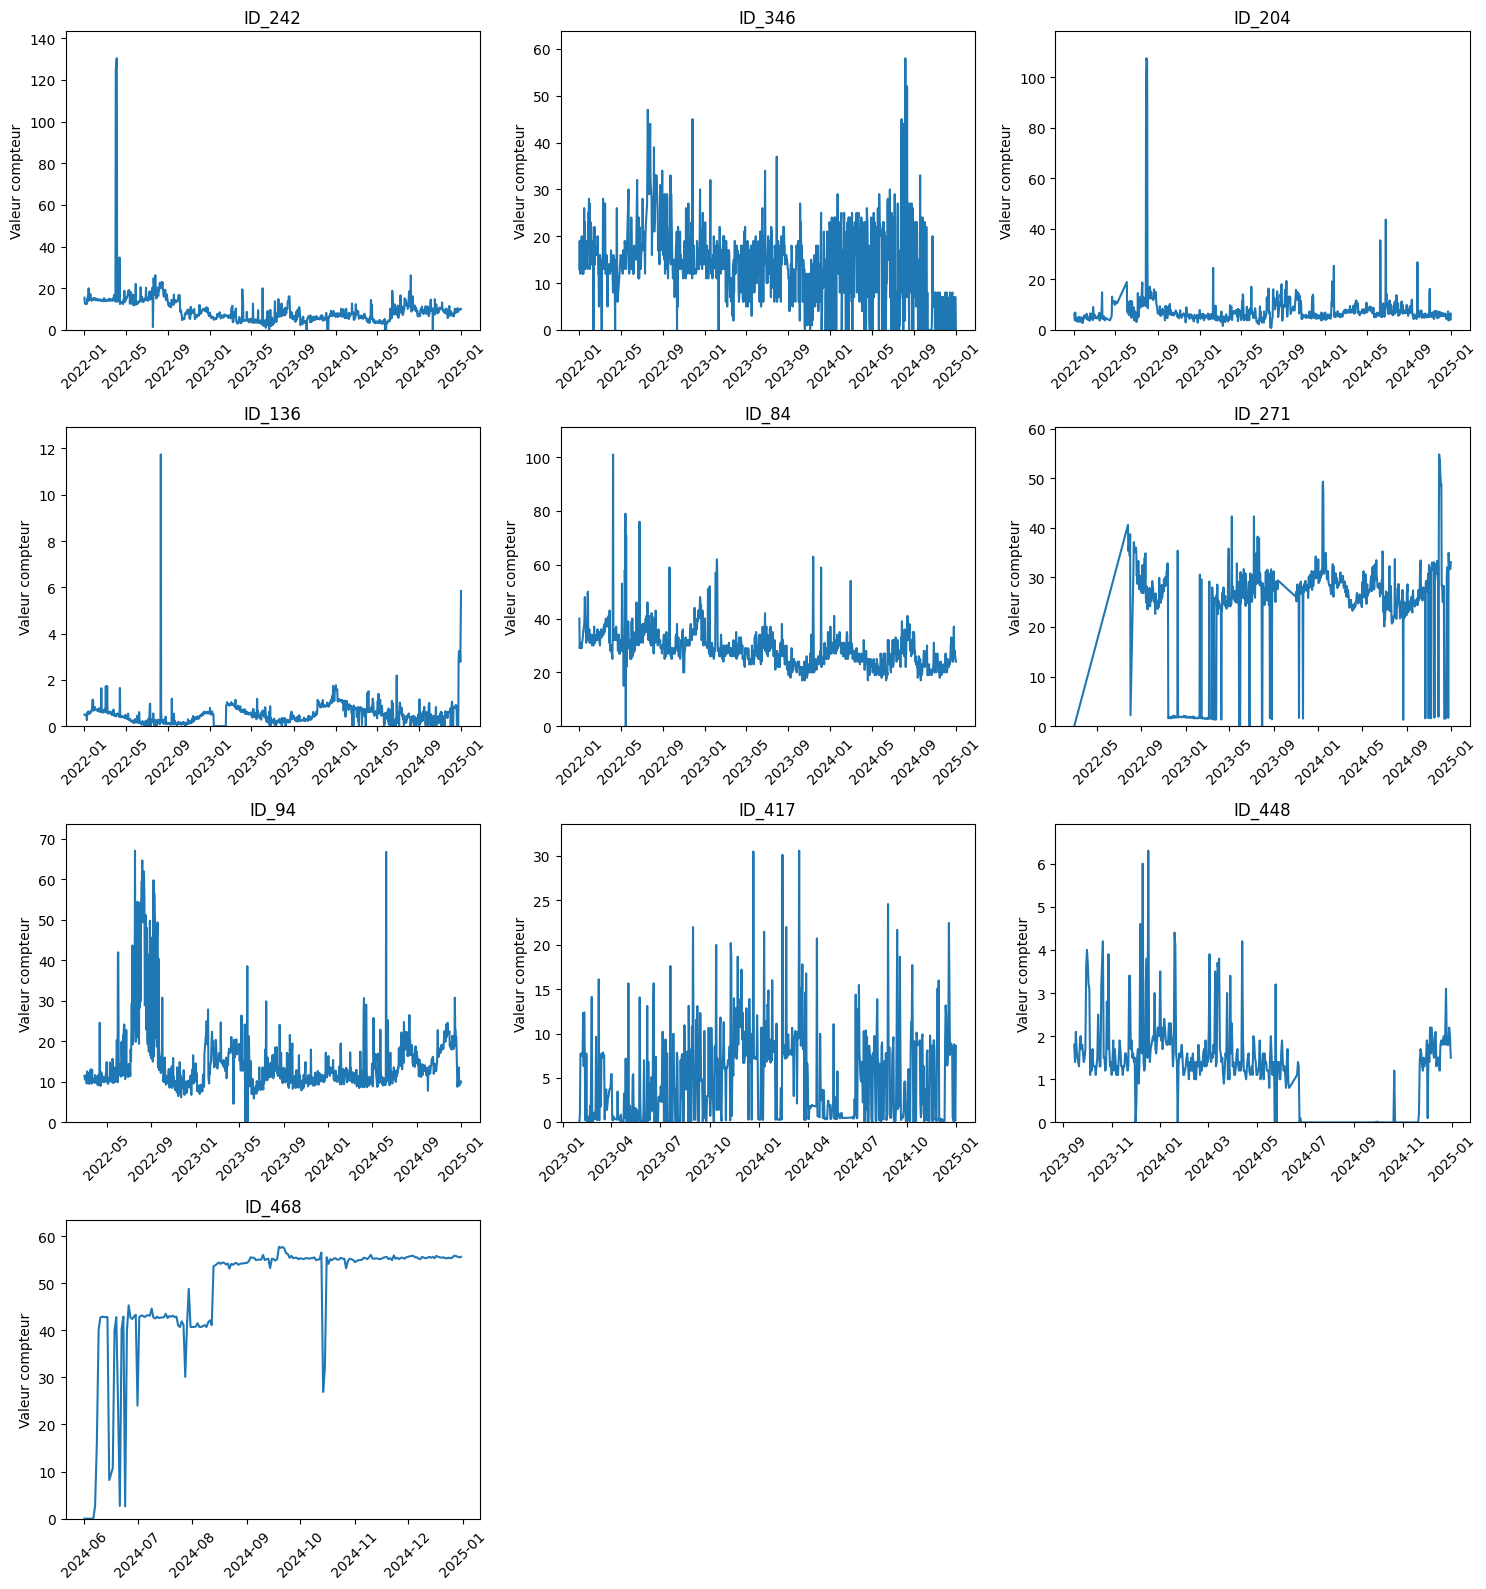

In [93]:
libelles_aleatoires = np.random.choice(
    data["libelle"].unique(),
    size=10,
    replace=False
)
impression(data[data['libelle'].isin(libelles_aleatoires)])

L'observation des compteurs montrent :
- valeurs manquantes
- valeurs nulles
- valeurs pics (valeur significativement élecvée pendant une période très courte)

## nettoyage

In [94]:
# retirer valeur nulles
data[data['valeur_active']==0]=np.nan
data = data[data["valeur_active"].notna()].copy()

In [95]:

# retirer les compteurs avec moins de 80% de données
nbre_valeur_par_compteur=(data
    .groupby('libelle')['valeur_active']
    .count())

In [96]:
nbre_valeur_par_compteur.describe()

count     485.000000
mean      733.523711
std       346.089127
min         1.000000
25%       487.000000
50%       856.000000
75%      1038.000000
max      1125.000000
Name: valeur_active, dtype: float64

Text(0.5, 1.0, 'nombre de compteur par nombre de valeur')

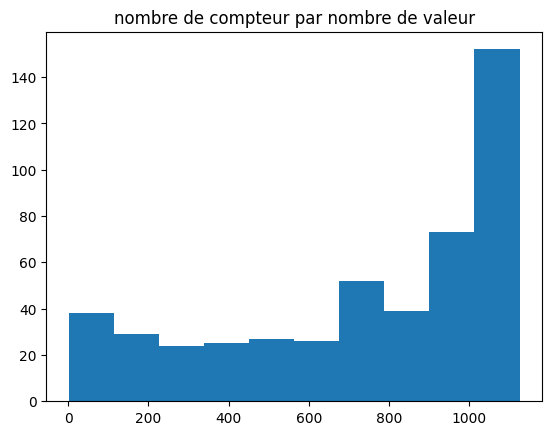

In [97]:
plt.hist(nbre_valeur_par_compteur)
plt.title('nombre de compteur par nombre de valeur')

In [98]:
seuil = 0.8 * nbre_valeur_par_compteur.max()
libelles_volumineux = nbre_valeur_par_compteur[nbre_valeur_par_compteur > seuil].index
data=data[data['libelle'].isin(libelles_volumineux)].copy()

In [99]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 225


## clusterisation

le client a préciser qu'il existait deux catégories de compteurs selon le débit. Nous allons séparer les compteurs en cluster et conserver le cluster principal.

In [102]:
moyenne_par_compteur=data.groupby('libelle')['valeur_active'].mean().reset_index()
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(moyenne_par_compteur[['valeur_active']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
moyenne_par_compteur["cluster"] = labels

In [103]:
moyenne_par_compteur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   libelle        225 non-null    object 
 1   valeur_active  225 non-null    float64
 2   cluster        225 non-null    int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 4.5+ KB


In [104]:
moyenne_par_compteur.groupby('cluster')['valeur_active'].agg(['count','max', 'mean'])

,count,max,mean
cluster,,,
0,200,71.733457,13.872179
1,25,392.242173,132.887798


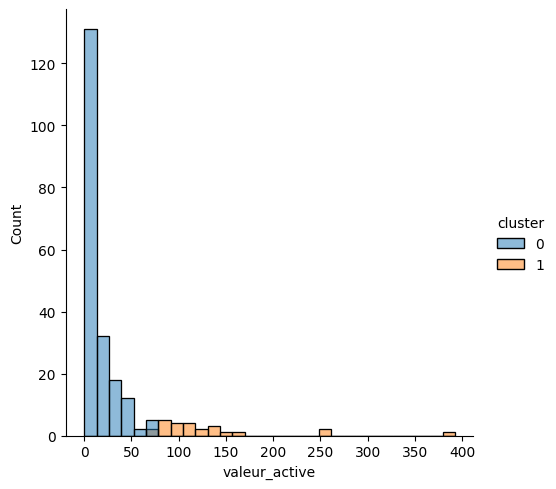

In [105]:
sns.displot(data=moyenne_par_compteur, x="valeur_active", hue="cluster")

In [106]:
cluster_principal = moyenne_par_compteur['cluster'].value_counts().idxmax()
libelles_principaux = moyenne_par_compteur[moyenne_par_compteur['cluster'] == cluster_principal]['libelle']
data=data[data['libelle'].isin(libelles_principaux)].copy()

In [107]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 200


## analyse saisonnalité et bruit

## Conclusion

L'observation des compteurs montrent :
- valeurs manquantes
- valeurs nulles ou quasi nulles
- valeurs pics (valeur significativement élecvée pendant une période très courte)
- valeurs constante
- peu de valeurs

Un nettoyage des données va être nécessaire pour obtenir des courbes temporelles exploitables :
- suppression des x% top et bottom quartile pour éliminer les pics et les valeurs nulles
- séparation en périodes conhérentes
- bouchage des trous unitaires
- normalisation des données pour les rendre comparables

# nettoyage des données

## suppression des valeurs nulles ou négatives

on commence par supprimer les valeurs nulles pour ne pas fausser les calculs de percentiles et écart type

In [11]:
data.loc[data["valeur_active"]<=0,"valeur_active"]=np.nan

## suppression des pics et creux

vérification normalité des données

In [12]:
import scipy.stats as ss

for libelle in libelles_train:
    mask=(data["libelle"]==libelle) & (data["valeur_active"].notna())
    print(f"proba que {libelle} diffère d'une loi normale {ss.normaltest(data[mask]["valeur_active"]).pvalue}")

proba que ID_1 diffère d'une loi normale 5.517462495064927e-103
proba que ID_2 diffère d'une loi normale 6.586060934234093e-10
proba que ID_3 diffère d'une loi normale 3.578707141277336e-71
proba que ID_4 diffère d'une loi normale 2.0583381031399434e-115
proba que ID_5 diffère d'une loi normale 2.0836597557269673e-118
proba que ID_6 diffère d'une loi normale nan
proba que ID_7 diffère d'une loi normale 8.285569144843347e-09
proba que ID_8 diffère d'une loi normale 0.32840384014890245
proba que ID_9 diffère d'une loi normale 1.6599991236993542e-37
proba que ID_10 diffère d'une loi normale 9.956313118809145e-46
proba que ID_11 diffère d'une loi normale 2.2476257307408975e-223
proba que ID_12 diffère d'une loi normale 7.347102520869802e-29
proba que ID_13 diffère d'une loi normale 1.3326108566171656e-48
proba que ID_14 diffère d'une loi normale 1.0002649861576354e-47
proba que ID_15 diffère d'une loi normale 4.83064814182755e-12
proba que ID_16 diffère d'une loi normale 7.382842676163831e

/tmp/ipykernel_4386/589135522.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(f"proba que {libelle} diffère d'une loi normale {ss.normaltest(data[mask]["valeur_active"]).pvalue}")


Après plusieurs essai, il apparait qu'un double filtre (sigma et percentile) permet d'adresser au mieux les différents profils de courbe

In [13]:
for libelle in libelles_train:
    mask=(data["libelle"]==libelle) & (data["valeur_active"].notna())
    subset = data[mask]["valeur_active"]

    # mu = subset.mean()
    # sigma = subset.std()

    # min_6s = mu - 3*sigma
    # max_6s = mu + 3*sigma

    # data.loc[mask & ((data["valeur_active"] < min_6s) | (data["valeur_active"] > max_6s)),
    #     "valeur_active"
    # ] = np.nan

    P1 = subset.quantile(0.02)
    P99=subset.quantile(0.98)

    data.loc[mask & ((data["valeur_active"] <= P1) | (data["valeur_active"] >= P99)),
        "valeur_active"
    ] = np.nan

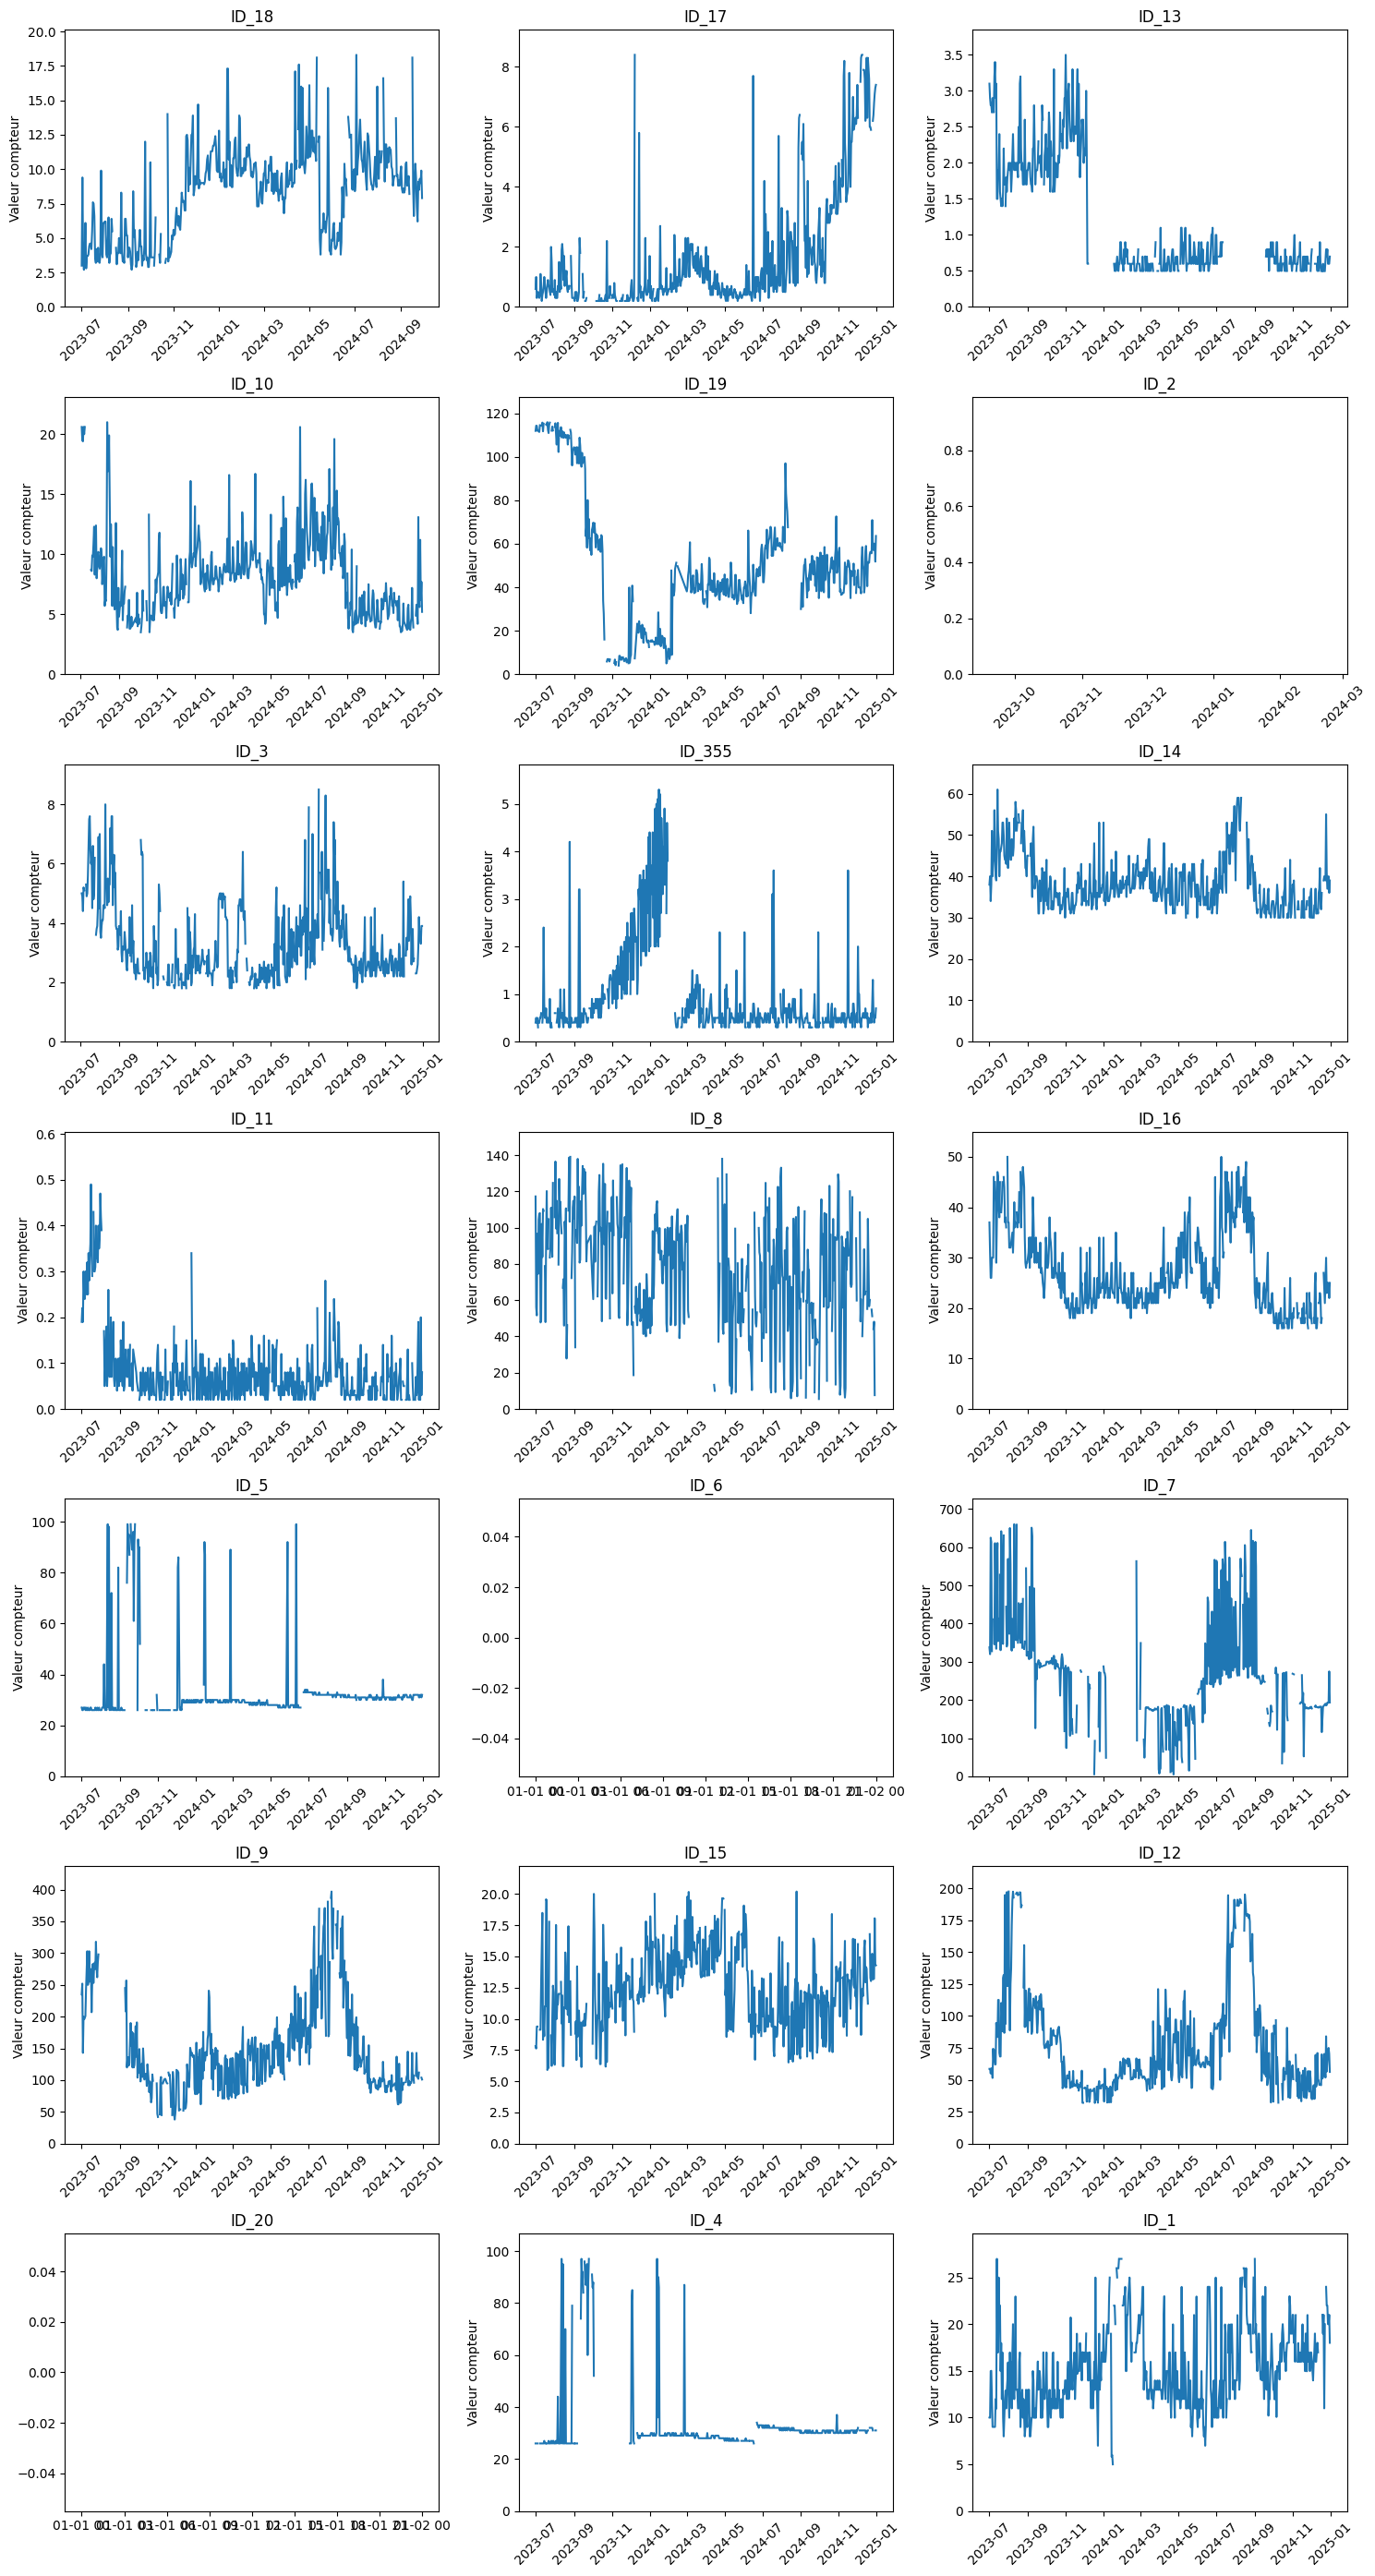

In [14]:
impression(data)

## remplissage des trous

Pour combler les trous, il faut ré-échantillonner les dates à une fréquence de la journée puis interpoler les valeurs manquantes

Pour ré-échantillonner, nous allons utiliser la méthode pandas resample. Elle nécessite que les dates soient sur l'index. Pour cela, nous allons créer une série par compteur.

Pour interpoler les valeurs manquantes, nous allons utiliser la méthode Pandas interpolate.

seules les séries avec plus 365 valeurs (=1 an) sont conservés

In [15]:
for libelle in libelles_train:
    mask=(data["libelle"]==libelle) & (data["valeur_active"].notna())
    print(f"libelle {libelle} taille {mask.sum()}")

libelle ID_1 taille 522
libelle ID_2 taille 7
libelle ID_3 taille 508
libelle ID_4 taille 457
libelle ID_5 taille 507
libelle ID_6 taille 0
libelle ID_7 taille 417
libelle ID_8 taille 456
libelle ID_9 taille 467
libelle ID_10 taille 520
libelle ID_11 taille 513
libelle ID_12 taille 527
libelle ID_13 taille 405
libelle ID_14 taille 513
libelle ID_15 taille 497
libelle ID_16 taille 513
libelle ID_17 taille 503
libelle ID_18 taille 432
libelle ID_19 taille 496
libelle ID_20 taille 0
libelle ID_355 taille 508


### création des séries avec plus de 365 valeur_active

In [16]:
dict_series = {}

for libelle in libelles_train:
    mask=(data["libelle"]==libelle) & (data["valeur_active"].notna())
    if mask.sum() >= 365:
        dict_series[libelle]=data[mask].set_index("date")["valeur_active"]

### ré-échantillonner et interpoller

On fait le choix de standardiser pour centrer la courbe sur zero ce qui facilite l'observation de la tendance, et cela conserve l'amplitude

In [17]:
for libelle, serie in dict_series.items():
    taille_init=serie.size
    serie=serie.resample("D").mean()
    serie=serie.interpolate(method='time')
    dict_series[libelle]=serie
    print(f"serie {libelle} passe de {taille_init} à {serie.size} points")

serie ID_1 passe de 522 à 550 points
serie ID_3 passe de 508 à 548 points
serie ID_4 passe de 457 à 550 points
serie ID_5 passe de 507 à 550 points
serie ID_7 passe de 417 à 550 points
serie ID_8 passe de 456 à 550 points
serie ID_9 passe de 467 à 550 points
serie ID_10 passe de 520 à 548 points
serie ID_11 passe de 513 à 550 points
serie ID_12 passe de 527 à 550 points
serie ID_13 passe de 405 à 550 points
serie ID_14 passe de 513 à 550 points
serie ID_15 passe de 497 à 550 points
serie ID_16 passe de 513 à 550 points
serie ID_17 passe de 503 à 550 points
serie ID_18 passe de 432 à 457 points
serie ID_19 passe de 496 à 550 points
serie ID_355 passe de 508 à 550 points


ID_13 avant nettoyage


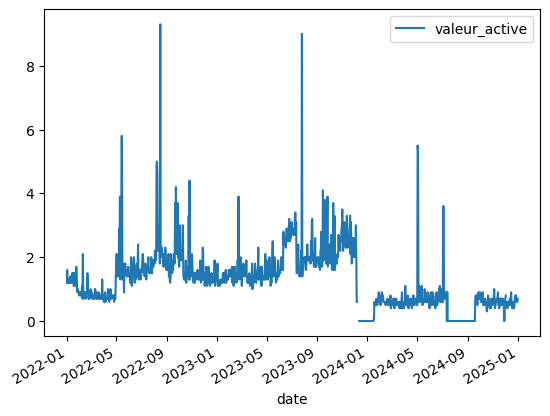

ID_13 après interpolation


<Axes: xlabel='date'>

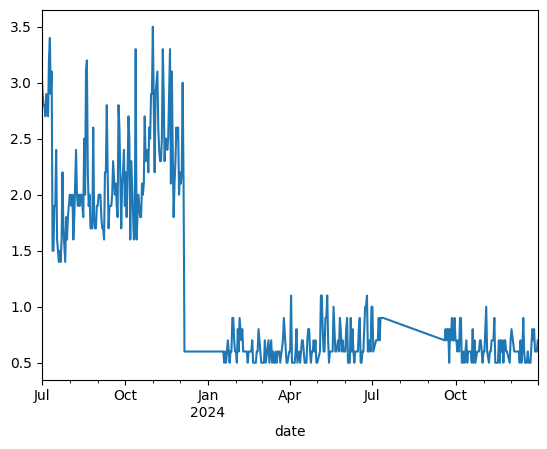

In [18]:
libelle_show='ID_13'
print(f"{libelle_show} avant nettoyage")
data_eau[(data_eau["date"]>='2022')&(data_eau["libelle"]==libelle_show)][["date","valeur_active"]].set_index("date").plot()
plt.show()
print(f"{libelle_show} après interpolation")
dict_series[libelle_show].plot()

### standardization et log

ID_355 avant standardization


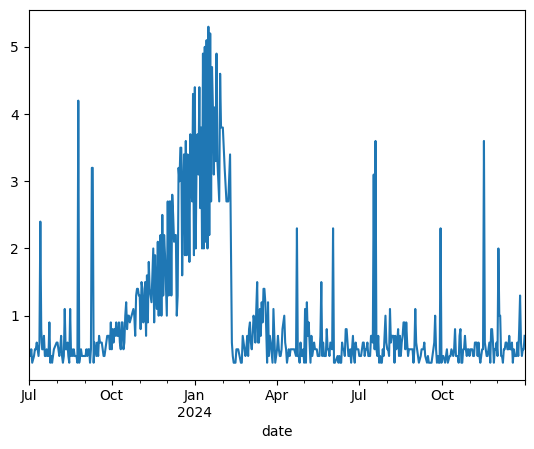

ID_355 après standardization


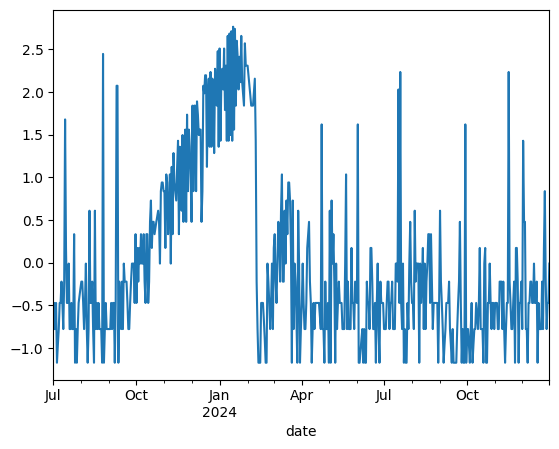

In [19]:
libelle_show='ID_355'
print(f"{libelle_show} avant standardization")
dict_series[libelle_show].plot()
plt.show()
for libelle, serie in dict_series.items():
    serie=np.log(serie)
    serie=(serie-serie.mean())/serie.std()
    dict_series[libelle]=serie
print(f"{libelle_show} après standardization")
dict_series[libelle_show].plot()
plt.show()

## conclusion

Les courbes obtenues sont continues et d'avantage cohérentes.

<Axes: xlabel='date'>

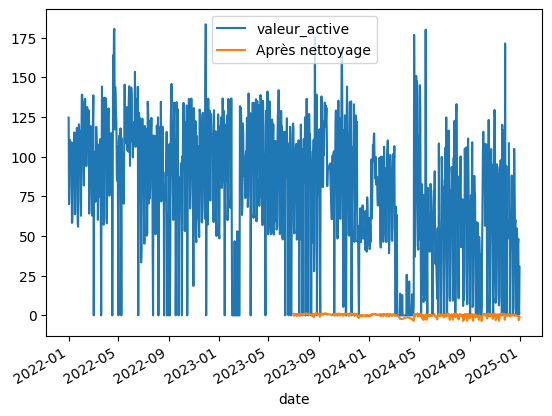

In [20]:
libelle_show='ID_8'
data_eau[(data_eau["date"]>='2022')&(data_eau["libelle"]==libelle_show)][["date","valeur_active"]].set_index("date").plot(label="Avant nettoyage", legend=True)
dict_series[libelle_show].plot(label="Après nettoyage", legend=True)

Text(0, 0.5, 'Après nettoyage')

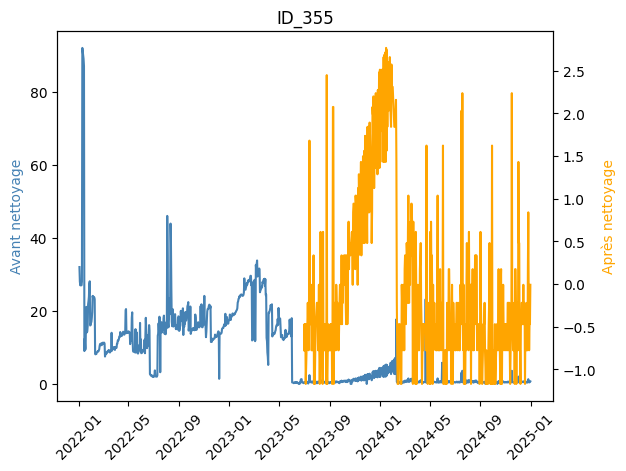

In [21]:
libelle_show='ID_355'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_eau[(data_eau["date"]>='2022')&(data_eau["libelle"]==libelle_show)][["date","valeur_active"]].set_index("date"),color='steelblue')
ax2.plot(dict_series[libelle_show], color='orange')
ax1.tick_params(axis='x',labelrotation=45)
plt.title(libelle_show)
ax1.set_ylabel('Avant nettoyage', color='steelblue')
ax2.set_ylabel('Après nettoyage', color='orange')


# Recherche de la tendance

Nous souhaitons identifier la fuite ID_355 de février 2024

<Axes: title={'center': 'ID_355'}, xlabel='date'>

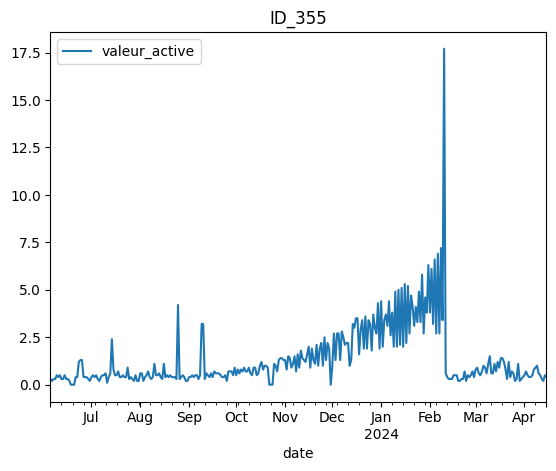

In [22]:
libelle="ID_355"
start_date = "2023-06-05"
end_date = "2024-04-15"
filter=(data_eau["libelle"]==libelle) & (data_eau["date"] >= start_date) & (data_eau["date"]<= end_date)
data_eau[filter].plot(x="date", y="valeur_active",title=libelle)

## utilisation de la moyenne mobile

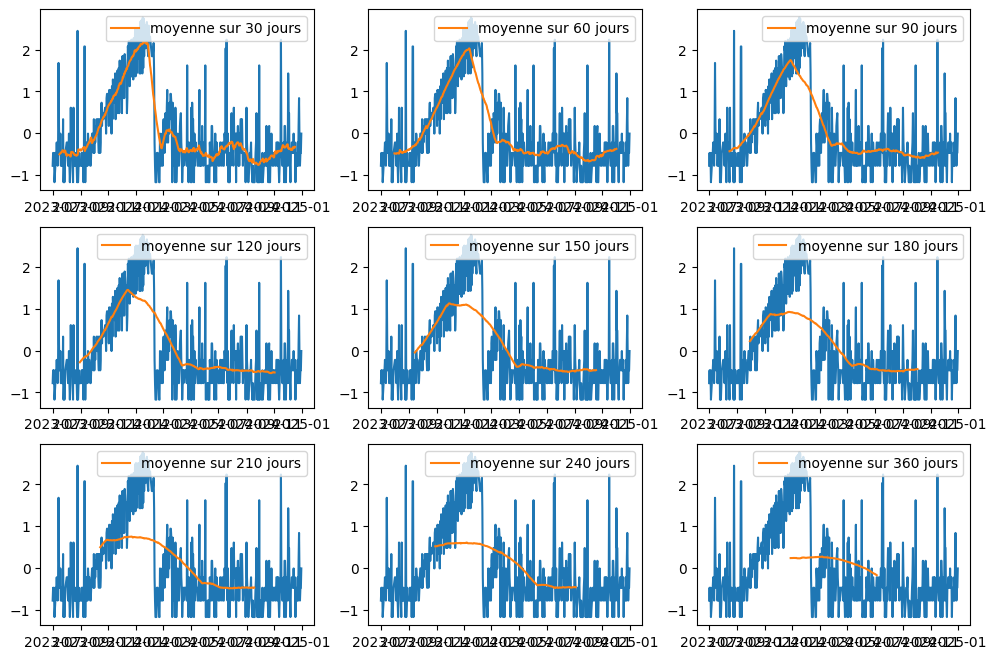

In [23]:
win = [30, 60, 90, 120, 150, 180, 210, 240, 360]
fig = plt.figure(figsize=(12,8))
libelle_show='ID_355'
y=dict_series[libelle_show]

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(y)
    ax.plot(y.rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} jours")
    ax.legend()


La moyenne mobile sur 60 jours semblent donner des résultats interessants.

## utilisation de seasonal_decompose

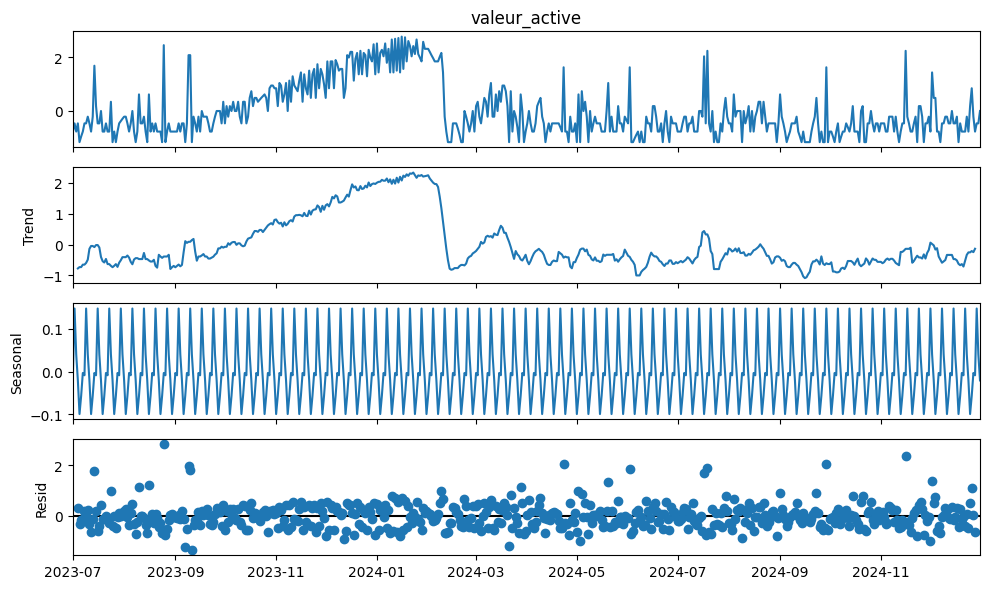

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomp = seasonal_decompose(y, model='additive') #on utilise additive car nous avons déjà transformé nos data avec log

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()


## Utilisation de la transformée de fourrier

la consommation d'eau est saisonnière avec des périodes annuelles, hebdomadaires, journalière. En décomposant avec la transformée de fourrier, nous pouvons extraire les composantes qui ne sont pas saisonnières.

In [ ]:
def decompose_tot(s):
    N = len(s)                     # nombre de points
    Y = np.fft.fft(s.values)       # coefficients FFT
    freqs = np.fft.fftfreq(N, 1)  # fréquences en cycles / jour

    signal = pd.Series(0.0, index=s.index)
    t=pd.Series(range(0,N), index=s.index)

    for i,freq in enumerate(freqs):
        # coefficient complexe à cette fréquence
        # fréquence est un float entre -0.5 et 0.5 : 0.5 est une variation quotidienne (2 jours), 0 est une constante (moyenne)
        # ainsi la variation annuelle correspond à une fréquence de 1/365
        # et une variation hebdo à une fréquence de 1/7
        if abs(freq) <=1/6 and abs(freq) >= 1/400:
            C = Y[i]

            # amplitude réelle de la composante
            amplitude = np.abs(C) * 1 / N   # normalisation FFT réelle

            # phase en radians
            phase = np.angle(C)

            signal += amplitude*np.cos(2 * np.pi * t*freq + phase)

    return signal

In [ ]:
def spectre(df):
    # calcul de la transformee de Fourier et des frequences
    fourier = np.fft.fft(df["valeur_active"])
    n = signal.size
    freq = np.fft.fftfreq(n, d=dt)

    # affichage de la transformee de Fourier
    plt.subplot(212)
    plt.plot(freq, fourier.real, label="real")
    plt.plot(freq, fourier.imag, label="imag")
    plt.legend()

    plt.show()

Text(0.5, 1.0, 'ID_1')

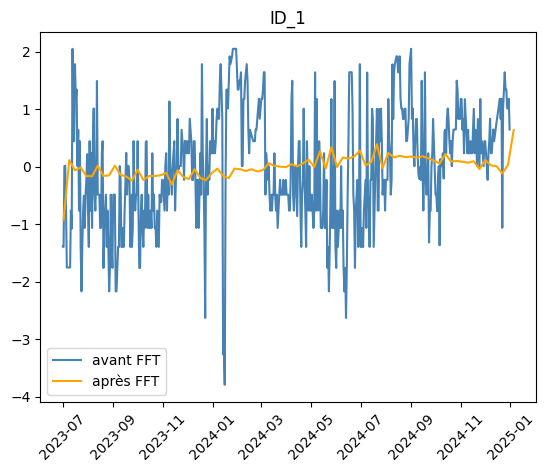

In [26]:
libelle_show='ID_1'
resample="W"

serie=dict_series[libelle_show].loc['july-2023':]
serie_rs=serie.resample(resample).mean()
serie_fft=decompose_tot(serie).resample(resample).mean()

fig, ax = plt.subplots()
ax.plot(serie,color='steelblue', label="avant FFT")
ax.plot(serie_rs-serie_fft, color='orange', label="après FFT")
ax.tick_params(axis='x',labelrotation=45)
ax.legend()
plt.title(libelle_show)


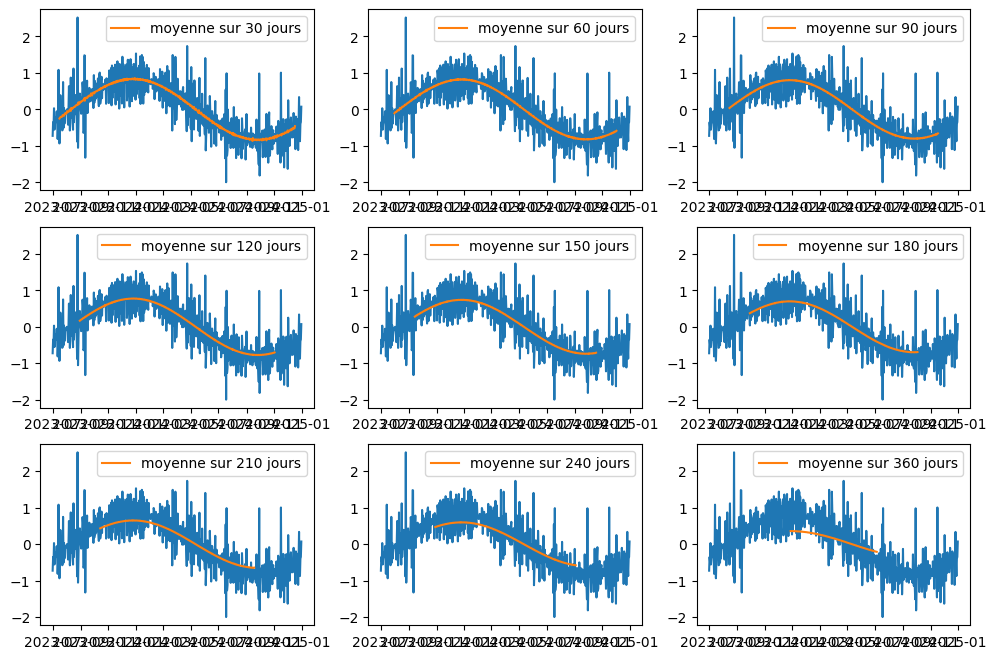

In [27]:
win = [30, 60, 90, 120, 150, 180, 210, 240, 360]
fig = plt.figure(figsize=(12,8))
libelle_show='ID_355'
y=(dict_series[libelle_show]-decompose_tot(dict_series[libelle_show]))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(y)
    ax.plot(y.rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} jours")
    ax.legend()

# biblio

utilisation de pandas échantillonage et interpolation : https://stackoverflow.com/questions/30530001/python-pandas-time-series-interpolation-and-regularization

méthode de décomposition d'une série temporelle : https://blog.statoscop.fr/timeseries-4.html